In [1]:
!pip install -q torch pandas scikit-learn matplotlib transformers openpyxl

In [2]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict
import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
from sklearn.model_selection import train_test_split

df = pd.read_excel('dataset.xlsx').drop('Unnamed: 0', axis=1)


df_train, df_test = train_test_split(df, random_state=77, test_size=0.30, shuffle=True)
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (3063, 19), Test: (656, 19), Valid: (657, 19)


In [4]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
test_text = "Test sentence"
encodings = tokenizer.encode_plus(test_text,
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length",
                                  return_attention_mask = True,
                                  return_tensors = "pt")

encodings

{'input_ids': tensor([[ 101, 3231, 6251,  102,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['text'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [7]:
target_list = df.columns[2:]

In [8]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-05

In [9]:
train_dataset = Dataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = Dataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = Dataset(df_test, tokenizer, MAX_LEN, target_list)

In [10]:
next(iter(train_dataset))

{'input_ids': tensor([  101,  2054,  2097,  2148,  4420,  1005,  1055, 17376,  2022,  1999,
         18540,  2475,  1029,  1008,  3141,  3980,  2006, 18804, 28703,  1024,
          1008,  1008,  1031,  2054,  2097,  2859,  1005,  1055,  2561, 17376,
          3446,  2022,  1999, 18540,  2487,  1029,  1033,  1006, 16770,  1024,
          1013,  1013,  7479,  1012, 18804, 28703,  1012,  4012,  1013,  3980,
          1013,  6486, 28154,  1013,  2822,  1011, 17376,  1011,  1999,  1011,
         18540,  2487,  1013,  1007,  1008,  1031,  2054,  2097,  2022,  5872,
          1005,  1055,  2336,  2566,  2450,  1999,  1996,  2095, 18540,  2487,
          1029,  1033,  1006, 16770,  1024,  1013,  1013,  7479,  1012, 18804,
         28703,  1012,  4012,  1013,  3980,  1013,  6275, 17465,  1013,  5872,
          1011, 17376,  1011,  1999,  1011, 18540,  2487,  1013,  1007,  1008,
          1031,  2054,  2097,  5872,  1005,  1055,  2561, 17376,  3446,  2022,
          1999, 16798,  2509,  1029,  1

In [11]:
train_data_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [12]:
len(target_list)

17

In [13]:
target_list

Index(['artificial intelligence', 'computing and math', 'cryptocurrencies',
       'economy & business', 'elections', 'environment & climate',
       'geopolitics', 'health & pandemics', 'law', 'metaculus',
       'natural sciences', 'nuclear technology & risks', 'politics',
       'social sciences', 'space', 'sports & entertainment', 'technology'],
      dtype='object')

In [14]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 17)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()

# for param in model.bert_model.parameters():
#     param.requires_grad = False

model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [16]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = LEARNING_RATE)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):

    losses = []
    correct_predictions = 0
    num_samples = 0

    model.train()

    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader),
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        # training accuracy
        _, preds = torch.max(outputs, dim=1) # batch dim
        _, targ = torch.max(targets, dim=1)  # batch dim
        num_samples += len(targ)  # technically adding batch size
        correct_predictions += torch.sum(preds == targ)

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Update progress bar
        #loop.set_description(f"")
        #loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)


In [18]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            _, preds = torch.max(outputs, dim=1) # batch dim
            _, targ = torch.max(targets, dim=1)  # batch dim
            num_samples += len(targ)  # technically adding batch size
            correct_predictions += torch.sum(preds == targ)

    return float(correct_predictions)/num_samples, np.mean(losses)


In [19]:
history = defaultdict(list)
best_accuracy = 0

from google.colab import files

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_accuracy = val_acc

Epoch 1/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.4629, val_loss=0.3125 train_acc=0.2393, val_acc=0.4201
Epoch 2/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.2968, val_loss=0.2557 train_acc=0.3741, val_acc=0.5845
Epoch 3/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.2479, val_loss=0.2117 train_acc=0.4969, val_acc=0.6073
Epoch 4/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.2093, val_loss=0.1821 train_acc=0.5514, val_acc=0.6240
Epoch 5/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.1827, val_loss=0.1619 train_acc=0.5883, val_acc=0.6484
Epoch 6/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.1609, val_loss=0.1461 train_acc=0.6259, val_acc=0.6575
Epoch 7/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.1443, val_loss=0.1345 train_acc=0.6481, val_acc=0.6788
Epoch 8/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.1299, val_loss=0.1238 train_acc=0.6814, val_acc=0.7260
Epoch 9/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.1168, val_loss=0.1147 train_acc=0.7068, val_acc=0.7154
Epoch 10/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.1052, val_loss=0.1086 train_acc=0.7016, val_acc=0.7412
Epoch 11/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.0957, val_loss=0.1026 train_acc=0.7378, val_acc=0.7169
Epoch 12/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.0865, val_loss=0.0983 train_acc=0.7369, val_acc=0.7199
Epoch 13/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.0786, val_loss=0.0943 train_acc=0.7320, val_acc=0.7093
Epoch 14/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.0718, val_loss=0.0913 train_acc=0.7310, val_acc=0.7123
Epoch 15/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.0655, val_loss=0.0887 train_acc=0.7307, val_acc=0.6941
Epoch 16/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.0603, val_loss=0.0868 train_acc=0.7287, val_acc=0.6941
Epoch 17/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.0555, val_loss=0.0849 train_acc=0.7336, val_acc=0.6910
Epoch 18/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.0513, val_loss=0.0829 train_acc=0.7326, val_acc=0.6651
Epoch 19/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.0472, val_loss=0.0822 train_acc=0.7294, val_acc=0.7275
Epoch 20/20


  0%|          | 0/96 [00:00<?, ?it/s]

train_loss=0.0435, val_loss=0.0804 train_acc=0.7271, val_acc=0.6849


In [26]:
raw_text = "Will the European Union meet its 2030 targets under the Paris Climate Treaty?"

encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [27]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)

In [28]:
prediction

tensor([5], device='cuda:0')

In [30]:
target_list[5]

'environment & climate'

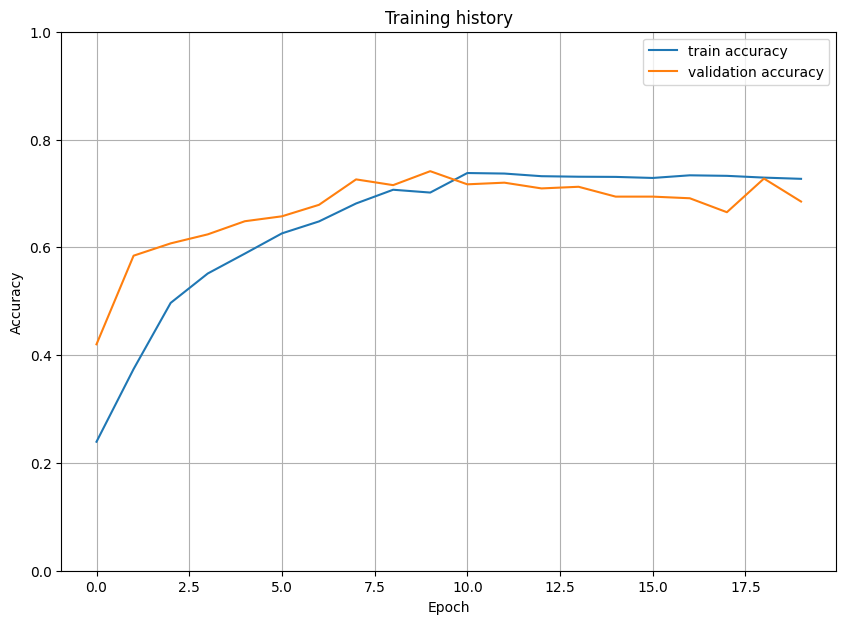

In [24]:
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

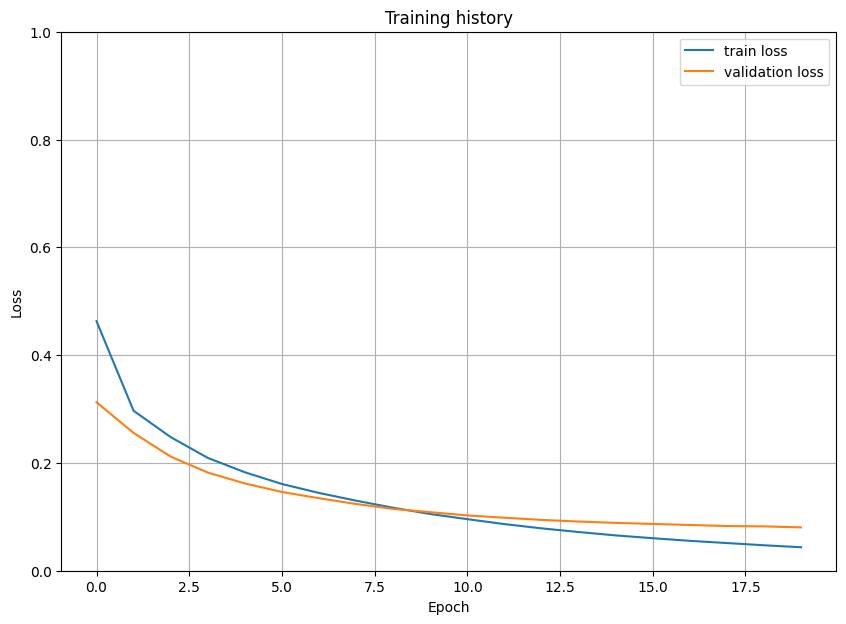

In [25]:
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

In [31]:
torch.save(model.state_dict(), 'model.pth')